In [1]:
!pip install duckdb scikit-learn -q


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [3]:
con = duckdb.connect()
con.execute("SET s3_region='us-east-1'")
S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"


In [4]:
con = duckdb.connect()
con.execute("SET s3_region='us-east-1'")
S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"

DOSE_MAPPING_REP1 = {
    4917: '5 mg/kg',  4918: 'Vehicle',  4919: '25 mg/kg',
    4920: '25 mg/kg', 4921: '5 mg/kg',  4922: 'Vehicle',
    4923: 'Vehicle',  4924: '25 mg/kg', 4925: '5 mg/kg'
}
DOSE_MAPPING_REP2 = {
    4926: '25 mg/kg', 4927: '5 mg/kg',  4928: 'Vehicle',
    4929: 'Vehicle',  4930: '25 mg/kg', 4931: '5 mg/kg',
    4932: '5 mg/kg',  4933: '25 mg/kg', 4934: 'Vehicle'
}

INJECTION_EVENTS = [
    {
        'name': 'Replicate 1, Dose 1',
        'short_name': 'Rep1_Dose1',
        'injection_time_utc': pd.Timestamp('2025-01-14 11:00:00'),
        'dates_to_load': ['2025-01-13', '2025-01-14', '2025-01-15'],
        'cages': list(DOSE_MAPPING_REP1.keys()),
        'dose_mapping': DOSE_MAPPING_REP1,
    },
    {
        'name': 'Replicate 1, Dose 2',
        'short_name': 'Rep1_Dose2',
        'injection_time_utc': pd.Timestamp('2025-01-17 22:00:00'),
        'dates_to_load': ['2025-01-17', '2025-01-18', '2025-01-19'],
        'cages': list(DOSE_MAPPING_REP1.keys()),
        'dose_mapping': DOSE_MAPPING_REP1,
    },
    {
        'name': 'Replicate 2, Dose 1',
        'short_name': 'Rep2_Dose1',
        'injection_time_utc': pd.Timestamp('2025-01-28 22:00:00'),
        'dates_to_load': ['2025-01-28', '2025-01-29', '2025-01-30'],
        'cages': list(DOSE_MAPPING_REP2.keys()),
        'dose_mapping': DOSE_MAPPING_REP2,
    },
    {
        'name': 'Replicate 2, Dose 2',
        'short_name': 'Rep2_Dose2',
        'injection_time_utc': pd.Timestamp('2025-01-31 11:00:00'),
        'dates_to_load': ['2025-01-30', '2025-01-31', '2025-02-01'],
        'cages': list(DOSE_MAPPING_REP2.keys()),
        'dose_mapping': DOSE_MAPPING_REP2,
    }
]


In [5]:
QUICK_TEST = True

if QUICK_TEST:
    INJECTION_EVENTS = [INJECTION_EVENTS[0]]  # Rep1 Dose1 only
    print("*** QUICK TEST MODE: Using Rep1 Dose1 only ***\n")

*** QUICK TEST MODE: Using Rep1 Dose1 only ***



In [6]:
def load_cage_data(cage_id, date_str, dose_mapping, file_type, query_filter=""):
    path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{file_type}.parquet"
    query = f"""
    SELECT * FROM read_parquet('{path}')
    WHERE resolution = 60
    {query_filter}
    """
    try:
        df = con.execute(query).fetchdf()
        df['cage_id'] = cage_id
        df['dose_group'] = dose_mapping[cage_id]
        return df
    except Exception as e:
        return pd.DataFrame()

def load_injection_event_data(event, file_type, query_filter=""):
    print(f"  Loading: {event['name']}")
    dfs = []
    for date_str in event['dates_to_load']:
        for cage_id in event['cages']:
            df = load_cage_data(cage_id, date_str, event['dose_mapping'], file_type, query_filter)
            if not df.empty:
                dfs.append(df)
    
    if not dfs:
        return pd.DataFrame()
    
    df_all = pd.concat(dfs, ignore_index=True)
    df_all['time'] = pd.to_datetime(df_all['time'])
    df_all['minutes_from_injection'] = (
        df_all['time'] - event['injection_time_utc']
    ).dt.total_seconds() / 60
    df_all = df_all[
        (df_all['minutes_from_injection'] >= -180) &
        (df_all['minutes_from_injection'] <= 540)
    ]
    df_all['event'] = event['short_name']
    return df_all

def load_all_events(file_type, query_filter=""):
    all_data = []
    for event in INJECTION_EVENTS:
        df = load_injection_event_data(event, file_type, query_filter)
        if not df.empty:
            all_data.append(df)
    df_combined = pd.concat(all_data, ignore_index=True)
    print(f"  Total: {len(df_combined):,} rows")
    return df_combined

In [7]:
def load_all_events(file_type):
    all_data = []
    for event in INJECTION_EVENTS:
        df = load_injection_event_data(event, file_type)
        if not df.empty:
            all_data.append(df)
    if not all_data:
        return pd.DataFrame()
    return pd.concat(all_data, ignore_index=True)

# =============================================================================
# LOAD DATA FROM ALL THREE TABLES
# =============================================================================

print("="*60)
print("LOADING DATA FROM MULTIPLE TABLES")
print("="*60)

# 1. Activity features (locomotion, active, inactive, climbing)
print("\n1. Loading animal_activity_db (locomotion, active, inactive, climbing)...")
df_activity = load_all_events('animal_activity_db')
print(f"   Rows: {len(df_activity):,}")
print(f"   Metrics: {sorted(df_activity['name'].unique())}")

# 2. Drinking/feeding
print("\n2. Loading animal_drinking (drinking, feeding)...")
df_drinking = load_all_events('animal_drinking')
print(f"   Rows: {len(df_drinking):,}")
print(f"   Metrics: {sorted(df_drinking['name'].unique())}")

# # 3. Sleep and social (optional - can skip if too sparse)
# print("\n3. Loading animal_tsdb_mvp (sleep, social)...")
# df_tsdb = load_all_events('animal_tsdb_mvp')
# print(f"   Rows: {len(df_tsdb):,}")
# print(f"   Metrics: {sorted(df_tsdb['name'].unique())}")

# Combine all
df_all = pd.concat([df_activity, df_drinking], ignore_index=True)

print(f"\n" + "="*60)
print(f"COMBINED: {len(df_all):,} rows, {df_all['name'].nunique()} metrics")
print("="*60)
for name in sorted(df_all['name'].unique()):
    print(f"  - {name}")

LOADING DATA FROM MULTIPLE TABLES

1. Loading animal_activity_db (locomotion, active, inactive, climbing)...
  Loading: Replicate 1, Dose 1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   Rows: 60,312
   Metrics: ['animal_bouts.active', 'animal_bouts.climbing', 'animal_bouts.inactive', 'animal_bouts.locomotion']

2. Loading animal_drinking (drinking, feeding)...
  Loading: Replicate 1, Dose 1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   Rows: 38,544
   Metrics: ['animal_bouts.drinking', 'animal_bouts.feeding']


NameError: name 'df_tsdb' is not defined

In [11]:
df_drinking

,predicted_identity,time,resolution,name,value,units,version_str,organization_id,cage_id,study_id,...,run_id,animal_id,ULID,__index_level_0__,filename,source_file,date,dose_group,minutes_from_injection,event
0,browncheckered,2025-01-14 08:00:00,60,animal_bouts.drinking,0.0,time_in_seconds,v3.3,8,4917,1001,...,2025v3.3,9239,01JHHX7700R9CMNWP3ZEBP582H,0,s3://org-8-uploads-stage/pipeline/study_1001/2...,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,-180.0,Rep1_Dose1
1,browncheckered,2025-01-14 08:00:00,60,animal_bouts.feeding,0.0,time_in_seconds,v3.3,8,4917,1001,...,2025v3.3,9239,01JHHX7700R9WV8476JM5NRBFE,1,s3://org-8-uploads-stage/pipeline/study_1001/2...,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,-180.0,Rep1_Dose1
2,redbarred,2025-01-14 08:00:00,60,animal_bouts.drinking,0.0,time_in_seconds,v3.3,8,4917,1001,...,2025v3.3,9240,01JHHX77006BBC2ACXX0VFFXHY,2,s3://org-8-uploads-stage/pipeline/study_1001/2...,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,-180.0,Rep1_Dose1
3,redbarred,2025-01-14 08:00:00,60,animal_bouts.feeding,0.0,time_in_seconds,v3.3,8,4917,1001,...,2025v3.3,9240,01JHHX7700TWHX2AJ11BJ266AV,3,s3://org-8-uploads-stage/pipeline/study_1001/2...,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,-180.0,Rep1_Dose1
4,blackallwhite,2025-01-14 08:00:00,60,animal_bouts.drinking,0.0,time_in_seconds,v3.3,8,4917,1001,...,2025v3.3,9241,01JHHX7700KDMTG55B79WJTAFV,4,s3://org-8-uploads-stage/pipeline/study_1001/2...,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,-180.0,Rep1_Dose1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38539,browncheckered,2025-01-14 09:59:00,60,animal_bouts.feeding,0.0,time_in_seconds,v3.3,8,4925,1001,...,2025v3.3,9245,01JHJ413N0EXWBVB0GCFX5JEYA,1,s3://org-8-uploads-stage/pipeline/study_1001/2...,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,-61.0,Rep1_Dose1
38540,redbarred,2025-01-14 09:59:00,60,animal_bouts.drinking,0.0,time_in_seconds,v3.3,8,4925,1001,...,2025v3.3,9246,01JHJ413N0A5B87W74DRHCKCNR,2,s3://org-8-uploads-stage/pipeline/study_1001/2...,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,-61.0,Rep1_Dose1
38541,redbarred,2025-01-14 09:59:00,60,animal_bouts.feeding,0.0,time_in_seconds,v3.3,8,4925,1001,...,2025v3.3,9246,01JHJ413N0RRR5P69XWRM794ND,3,s3://org-8-uploads-stage/pipeline/study_1001/2...,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,-61.0,Rep1_Dose1
38542,blackallwhite,2025-01-14 09:59:00,60,animal_bouts.drinking,0.0,time_in_seconds,v3.3,8,4925,1001,...,2025v3.3,9247,01JHJ413N0B725229T7M17H04X,4,s3://org-8-uploads-stage/pipeline/study_1001/2...,s3://org-8-uploads-stage/pipeline/study_1001/2...,2025-01-14,5 mg/kg,-61.0,Rep1_Dose1


In [8]:
df_all = pd.concat([df_activity, df_drinking], ignore_index=True)

print(f"\n" + "="*60)
print(f"COMBINED: {len(df_all):,} rows, {df_all['name'].nunique()} metrics")
print("="*60)
for name in sorted(df_all['name'].unique()):
    print(f"  - {name}")


COMBINED: 98,856 rows, 6 metrics
  - animal_bouts.active
  - animal_bouts.climbing
  - animal_bouts.drinking
  - animal_bouts.feeding
  - animal_bouts.inactive
  - animal_bouts.locomotion


In [12]:
import os
os.makedirs('pcas_2', exist_ok=True)


In [13]:
print("\n" + "="*60)
print("PIVOTING DATA")
print("="*60)

df_pivot = df_all.pivot_table(
    index=['cage_id', 'dose_group', 'time', 'minutes_from_injection', 'animal_id'],
    columns='name',
    values='value',
    aggfunc='mean'
).reset_index()

df_pivot.columns.name = None
print(f"Shape: {df_pivot.shape}")


PIVOTING DATA
Shape: (19272, 11)


In [14]:
df_pivot

,cage_id,dose_group,time,minutes_from_injection,animal_id,animal_bouts.active,animal_bouts.climbing,animal_bouts.drinking,animal_bouts.feeding,animal_bouts.inactive,animal_bouts.locomotion
0,4917,5 mg/kg,2025-01-14 08:00:00,-180.0,9239,0.866667,NaN,0.00,0.0,0.133333,0.000000
1,4917,5 mg/kg,2025-01-14 08:00:00,-180.0,9240,0.550000,NaN,0.00,0.0,0.450000,0.000000
2,4917,5 mg/kg,2025-01-14 08:00:00,-180.0,9241,0.783333,NaN,0.00,0.0,0.200000,0.016667
3,4917,5 mg/kg,2025-01-14 08:01:00,-179.0,9239,1.000000,NaN,0.00,0.0,0.000000,NaN
4,4917,5 mg/kg,2025-01-14 08:01:00,-179.0,9240,0.316667,NaN,0.00,0.0,0.683333,NaN
...,...,...,...,...,...,...,...,...,...,...,...
19267,4925,5 mg/kg,2025-01-14 19:59:00,539.0,9246,0.683333,NaN,0.00,0.0,0.000000,0.316667
19268,4925,5 mg/kg,2025-01-14 19:59:00,539.0,9247,0.966667,NaN,0.00,0.0,0.016667,0.016667
19269,4925,5 mg/kg,2025-01-14 20:00:00,540.0,9245,0.750000,NaN,0.15,0.0,0.133333,0.116667
19270,4925,5 mg/kg,2025-01-14 20:00:00,540.0,9246,0.950000,NaN,0.00,0.0,0.000000,0.050000


In [15]:
feature_cols = [c for c in df_pivot.columns if 'animal_bouts' in c]
print(f"\nFeature columns ({len(feature_cols)}):")
for col in feature_cols:
    nan_pct = df_pivot[col].isna().sum() / len(df_pivot) * 100
    print(f"  {col}: {nan_pct:.1f}% NaN")

# Keep features with <50% NaN
good_features = [c for c in feature_cols if df_pivot[c].isna().sum() / len(df_pivot) < 0.5]
print(f"\nUsing {len(good_features)} features with <50% NaN")


Feature columns (6):
  animal_bouts.active: 0.2% NaN
  animal_bouts.climbing: 52.3% NaN
  animal_bouts.drinking: 0.0% NaN
  animal_bouts.feeding: 0.0% NaN
  animal_bouts.inactive: 4.7% NaN
  animal_bouts.locomotion: 30.0% NaN

Using 5 features with <50% NaN


In [16]:
def assign_time_window(minutes):
    if minutes < -60:
        return 'baseline'
    elif minutes < 0:
        return 'pre_injection'
    elif minutes < 30:
        return 'immediate'
    elif minutes < 90:
        return 'peak_early'
    elif minutes < 180:
        return 'peak_sustained'
    elif minutes < 300:
        return 'decline_early'
    elif minutes < 420:
        return 'decline_late'
    else:
        return 'post_6hr+'

In [17]:
df_pivot['time_window'] = df_pivot['minutes_from_injection'].apply(assign_time_window)


In [18]:
df_pivot

,cage_id,dose_group,time,minutes_from_injection,animal_id,animal_bouts.active,animal_bouts.climbing,animal_bouts.drinking,animal_bouts.feeding,animal_bouts.inactive,animal_bouts.locomotion,time_window
0,4917,5 mg/kg,2025-01-14 08:00:00,-180.0,9239,0.866667,NaN,0.00,0.0,0.133333,0.000000,baseline
1,4917,5 mg/kg,2025-01-14 08:00:00,-180.0,9240,0.550000,NaN,0.00,0.0,0.450000,0.000000,baseline
2,4917,5 mg/kg,2025-01-14 08:00:00,-180.0,9241,0.783333,NaN,0.00,0.0,0.200000,0.016667,baseline
3,4917,5 mg/kg,2025-01-14 08:01:00,-179.0,9239,1.000000,NaN,0.00,0.0,0.000000,NaN,baseline
4,4917,5 mg/kg,2025-01-14 08:01:00,-179.0,9240,0.316667,NaN,0.00,0.0,0.683333,NaN,baseline
...,...,...,...,...,...,...,...,...,...,...,...,...
19267,4925,5 mg/kg,2025-01-14 19:59:00,539.0,9246,0.683333,NaN,0.00,0.0,0.000000,0.316667,post_6hr+
19268,4925,5 mg/kg,2025-01-14 19:59:00,539.0,9247,0.966667,NaN,0.00,0.0,0.016667,0.016667,post_6hr+
19269,4925,5 mg/kg,2025-01-14 20:00:00,540.0,9245,0.750000,NaN,0.15,0.0,0.133333,0.116667,post_6hr+
19270,4925,5 mg/kg,2025-01-14 20:00:00,540.0,9246,0.950000,NaN,0.00,0.0,0.000000,0.050000,post_6hr+


In [19]:
print("\n" + "="*60)
print("RUNNING PCA")
print("="*60)

df_25mg = df_pivot[df_pivot['dose_group'] == '25 mg/kg'].copy()
print(f"25 mg/kg rows: {len(df_25mg):,}")

df_pca = df_25mg.dropna(subset=good_features).copy()
print(f"After dropna: {len(df_pca):,}")

X = df_pca[good_features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca['PC1'] = X_pca[:, 0]
df_pca['PC2'] = X_pca[:, 1]

print(f"\nExplained Variance:")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")


RUNNING PCA
25 mg/kg rows: 6,480
After dropna: 4,929

Explained Variance:
  PC1: 37.2%
  PC2: 24.2%



SAVING PLOTS


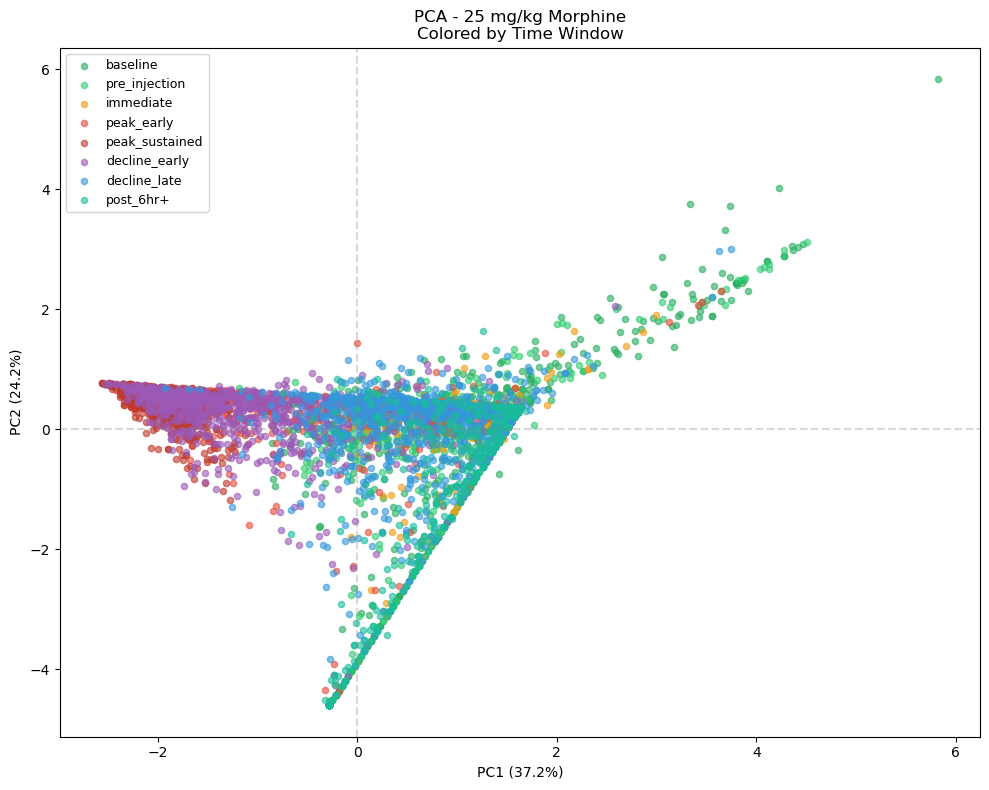

Saved: pcas_2/pca_morphine.png


In [20]:
print("\n" + "="*60)
print("SAVING PLOTS")
print("="*60)

window_colors = {
    'baseline': '#27ae60',
    'pre_injection': '#2ecc71',
    'immediate': '#f39c12',
    'peak_early': '#e74c3c',
    'peak_sustained': '#c0392b',
    'decline_early': '#9b59b6',
    'decline_late': '#3498db',
    'post_6hr+': '#1abc9c'
}
window_order = ['baseline', 'pre_injection', 'immediate', 'peak_early', 
                'peak_sustained', 'decline_early', 'decline_late', 'post_6hr+']

fig, ax = plt.subplots(figsize=(10, 8))
for window in window_order:
    mask = df_pca['time_window'] == window
    if mask.sum() > 0:
        ax.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
                   c=window_colors[window], label=window, alpha=0.6, s=20)

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("PCA - 25 mg/kg Morphine\nColored by Time Window")
ax.legend(loc='best', fontsize=9)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('pcas_2/pca_morphine.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: pcas_2/pca_morphine.png")

In [21]:
for feat in good_features:
    feat_name = feat.replace('animal_bouts.', '').replace('.', '_')
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'],
                         c=df_pca[feat], cmap='viridis', alpha=0.6, s=20)
    plt.colorbar(scatter, ax=ax, label=feat_name)
    
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    ax.set_title(f"PCA - 25 mg/kg Morphine\nColored by {feat_name}")
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'pcas_2/pca_{feat_name}.png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: pcas_2/pca_{feat_name}.png")

Saved: pcas_2/pca_active.png
Saved: pcas_2/pca_drinking.png
Saved: pcas_2/pca_feeding.png
Saved: pcas_2/pca_inactive.png
Saved: pcas_2/pca_locomotion.png


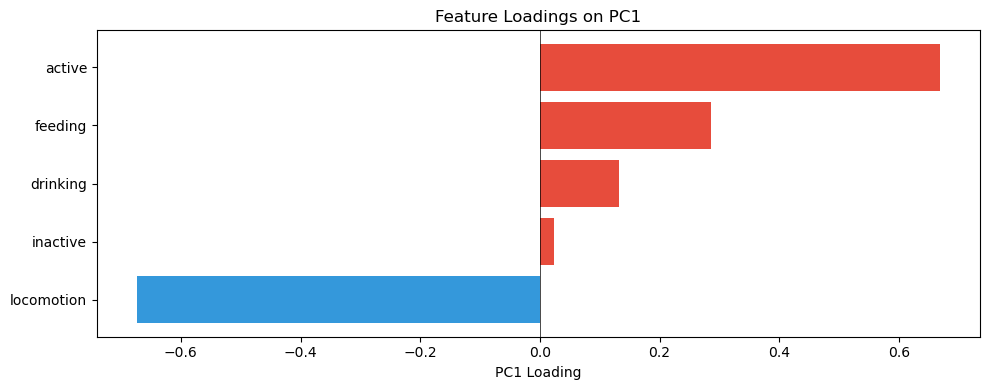

Saved: pcas_2/pca_loadings.png

✓ DONE!

Files saved:
  pcas/.ipynb_checkpoints
  pcas/pca_active.png
  pcas/pca_drinking.png
  pcas/pca_feeding.png
  pcas/pca_inactive.png
  pcas/pca_loadings.png
  pcas/pca_locomotion.png
  pcas/pca_morphine.png


In [23]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=good_features
).sort_values('PC1')

fig, ax = plt.subplots(figsize=(10, max(4, len(good_features)*0.5)))
colors = ['#e74c3c' if x > 0 else '#3498db' for x in loadings['PC1']]
ax.barh(range(len(loadings)), loadings['PC1'], color=colors)
ax.set_yticks(range(len(loadings)))
ax.set_yticklabels([c.replace('animal_bouts.', '') for c in loadings.index])
ax.set_xlabel('PC1 Loading')
ax.set_title('Feature Loadings on PC1')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.savefig('pcas_2/pca_loadings.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: pcas_2/pca_loadings.png")

print("\n" + "="*60)
print("✓ DONE!")
print("="*60)
print("\nFiles saved:")
for f in sorted(os.listdir('pcas_2')):
    print(f"  pcas/{f}")

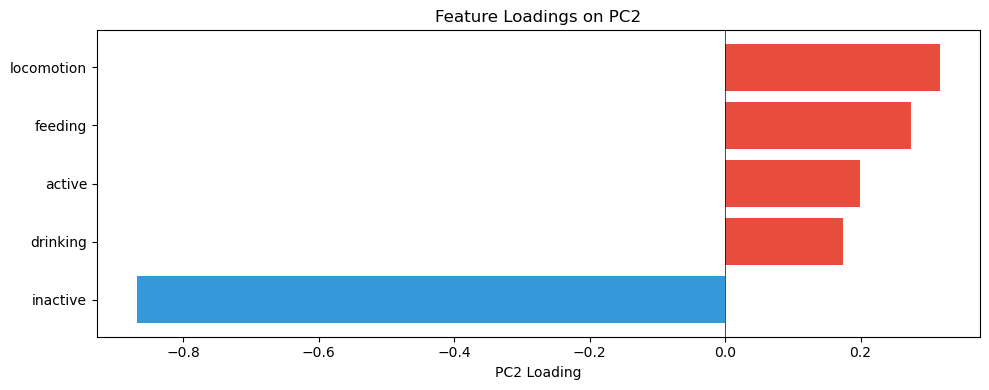

Saved: pcas_2/pca_loadings_pc2.png


In [24]:
# PC2 Loadings plot
loadings_pc2 = loadings.sort_values('PC2')

fig, ax = plt.subplots(figsize=(10, max(4, len(good_features)*0.5)))
colors = ['#e74c3c' if x > 0 else '#3498db' for x in loadings_pc2['PC2']]
ax.barh(range(len(loadings_pc2)), loadings_pc2['PC2'], color=colors)
ax.set_yticks(range(len(loadings_pc2)))
ax.set_yticklabels([c.replace('animal_bouts.', '') for c in loadings_pc2.index])
ax.set_xlabel('PC2 Loading')
ax.set_title('Feature Loadings on PC2')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.savefig('pcas_2/pca_loadings_pc2.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: pcas_2/pca_loadings_pc2.png")

## Aggregated features

In [25]:
corr_matrix = df_pivot[good_features].corr()
print(corr_matrix.round(2))

                         animal_bouts.active  animal_bouts.drinking  \
animal_bouts.active                     1.00                   0.03   
animal_bouts.drinking                   0.03                   1.00   
animal_bouts.feeding                    0.14                  -0.00   
animal_bouts.inactive                  -0.73                  -0.02   
animal_bouts.locomotion                -0.57                  -0.04   

                         animal_bouts.feeding  animal_bouts.inactive  \
animal_bouts.active                      0.14                  -0.73   
animal_bouts.drinking                   -0.00                  -0.02   
animal_bouts.feeding                     1.00                  -0.17   
animal_bouts.inactive                   -0.17                   1.00   
animal_bouts.locomotion                 -0.11                  -0.33   

                         animal_bouts.locomotion  
animal_bouts.active                        -0.57  
animal_bouts.drinking                 

In [26]:
print("\n" + "="*60)
print("FEATURE SELECTION")
print("="*60)

# Drop inactive (redundant with active)
features_to_use = [
    'animal_bouts.active',
    'animal_bouts.locomotion', 
    'animal_bouts.drinking',
    'animal_bouts.feeding'
]

# Verify they exist
features_to_use = [f for f in features_to_use if f in df_pivot.columns]
print(f"\nFeatures for PCA ({len(features_to_use)}):")
for f in features_to_use:
    print(f"  - {f}")


FEATURE SELECTION

Features for PCA (4):
  - animal_bouts.active
  - animal_bouts.locomotion
  - animal_bouts.drinking
  - animal_bouts.feeding


In [27]:
print("\n" + "="*60)
print("AGGREGATING TO 30-MINUTE BINS")
print("="*60)

# Create 30-minute bins
df_pivot['time_bin'] = (df_pivot['minutes_from_injection'] // 30) * 30

# Aggregate: mean of each feature within each 30-min bin, per animal
df_agg = df_pivot.groupby(
    ['cage_id', 'dose_group', 'animal_id', 'time_bin']
)[features_to_use].mean().reset_index()

# Add time window labels
def assign_time_window(minutes):
    if minutes < -60:
        return 'baseline'
    elif minutes < 0:
        return 'pre_injection'
    elif minutes < 30:
        return 'immediate'
    elif minutes < 90:
        return 'peak_early'
    elif minutes < 180:
        return 'peak_sustained'
    elif minutes < 300:
        return 'decline_early'
    elif minutes < 420:
        return 'decline_late'
    else:
        return 'post_6hr+'

df_agg['time_window'] = df_agg['time_bin'].apply(assign_time_window)

print(f"Before aggregation: {len(df_pivot):,} rows")
print(f"After aggregation: {len(df_agg):,} rows")
print(f"\nTime bins: {sorted(df_agg['time_bin'].unique())}")
print(f"\nRows per time window:")
print(df_agg['time_window'].value_counts())


AGGREGATING TO 30-MINUTE BINS
Before aggregation: 19,272 rows
After aggregation: 669 rows

Time bins: [-180.0, -150.0, -120.0, -90.0, -60.0, -30.0, 0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0, 300.0, 330.0, 360.0, 390.0, 420.0, 450.0, 480.0, 510.0, 540.0]

Rows per time window:
time_window
post_6hr+         135
baseline          108
decline_early     108
decline_late      108
peak_sustained     81
pre_injection      54
peak_early         51
immediate          24
Name: count, dtype: int64


In [28]:
print("\n" + "="*60)
print("RUNNING PCA ON AGGREGATED DATA")
print("="*60)

df_25mg_agg = df_agg[df_agg['dose_group'] == '25 mg/kg'].copy()
df_pca_agg = df_25mg_agg.dropna(subset=features_to_use).copy()

print(f"25 mg/kg aggregated rows: {len(df_pca_agg):,}")

X_agg = df_pca_agg[features_to_use].values
scaler_agg = StandardScaler()
X_agg_scaled = scaler_agg.fit_transform(X_agg)

pca_agg = PCA(n_components=2)
X_pca_agg = pca_agg.fit_transform(X_agg_scaled)

df_pca_agg['PC1'] = X_pca_agg[:, 0]
df_pca_agg['PC2'] = X_pca_agg[:, 1]

print(f"\nExplained Variance (aggregated):")
print(f"  PC1: {pca_agg.explained_variance_ratio_[0]*100:.1f}%")
print(f"  PC2: {pca_agg.explained_variance_ratio_[1]*100:.1f}%")
print(f"  Total: {sum(pca_agg.explained_variance_ratio_)*100:.1f}%")


RUNNING PCA ON AGGREGATED DATA
25 mg/kg aggregated rows: 216

Explained Variance (aggregated):
  PC1: 57.5%
  PC2: 22.3%
  Total: 79.8%



SAVING PLOTS


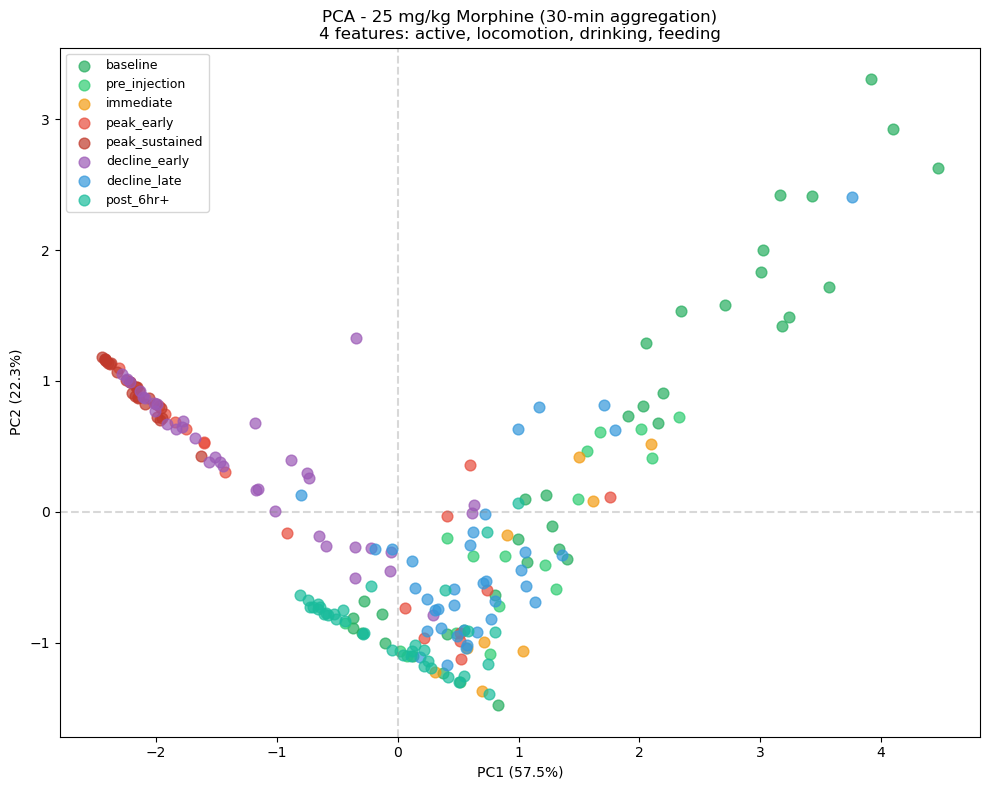

Saved: pcas_30min/pca_morphine.png


In [29]:
print("\n" + "="*60)
print("SAVING PLOTS")
print("="*60)

OUTPUT_DIR = 'pcas_30min'
os.makedirs(OUTPUT_DIR, exist_ok=True)

window_colors = {
    'baseline': '#27ae60',
    'pre_injection': '#2ecc71',
    'immediate': '#f39c12',
    'peak_early': '#e74c3c',
    'peak_sustained': '#c0392b',
    'decline_early': '#9b59b6',
    'decline_late': '#3498db',
    'post_6hr+': '#1abc9c'
}
window_order = ['baseline', 'pre_injection', 'immediate', 'peak_early', 
                'peak_sustained', 'decline_early', 'decline_late', 'post_6hr+']

fig, ax = plt.subplots(figsize=(10, 8))
for window in window_order:
    mask = df_pca_agg['time_window'] == window
    if mask.sum() > 0:
        ax.scatter(df_pca_agg.loc[mask, 'PC1'], df_pca_agg.loc[mask, 'PC2'],
                   c=window_colors[window], label=window, alpha=0.7, s=60)

ax.set_xlabel(f"PC1 ({pca_agg.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca_agg.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("PCA - 25 mg/kg Morphine (30-min aggregation)\n4 features: active, locomotion, drinking, feeding")
ax.legend(loc='best', fontsize=9)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/pca_morphine.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/pca_morphine.png")

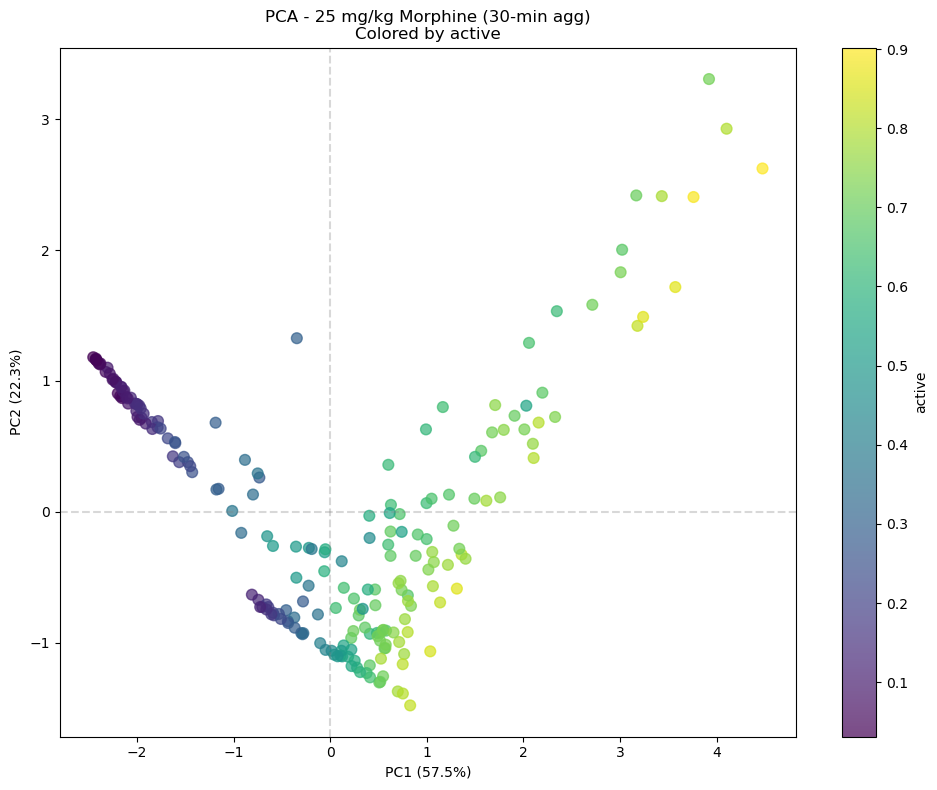

Saved: pcas_30min/pca_active.png


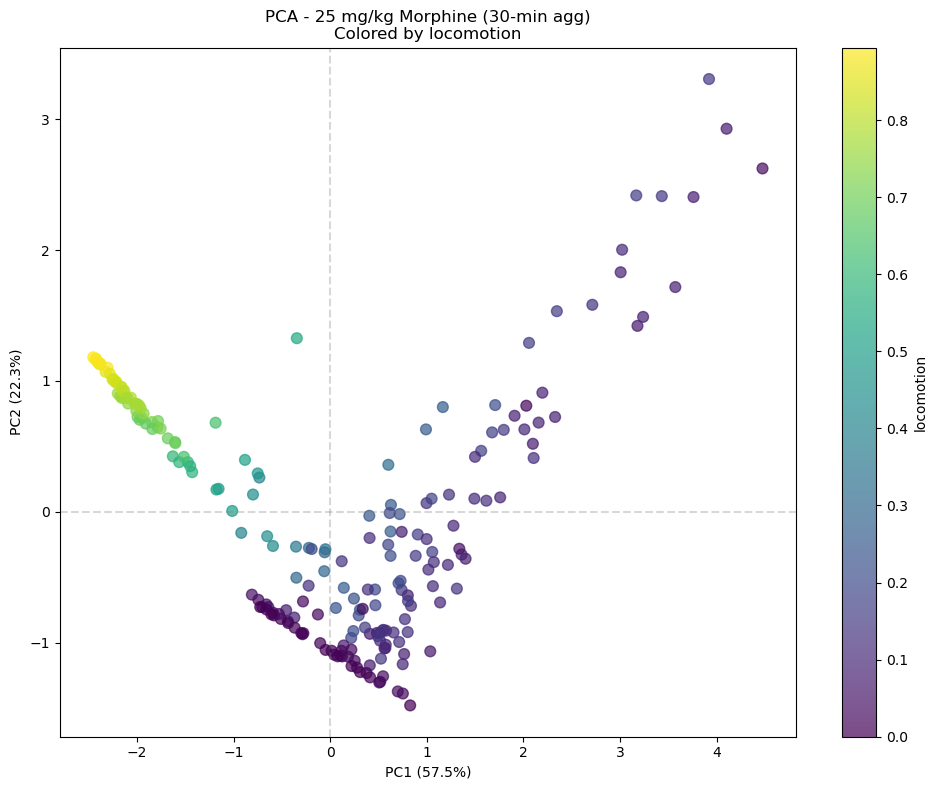

Saved: pcas_30min/pca_locomotion.png


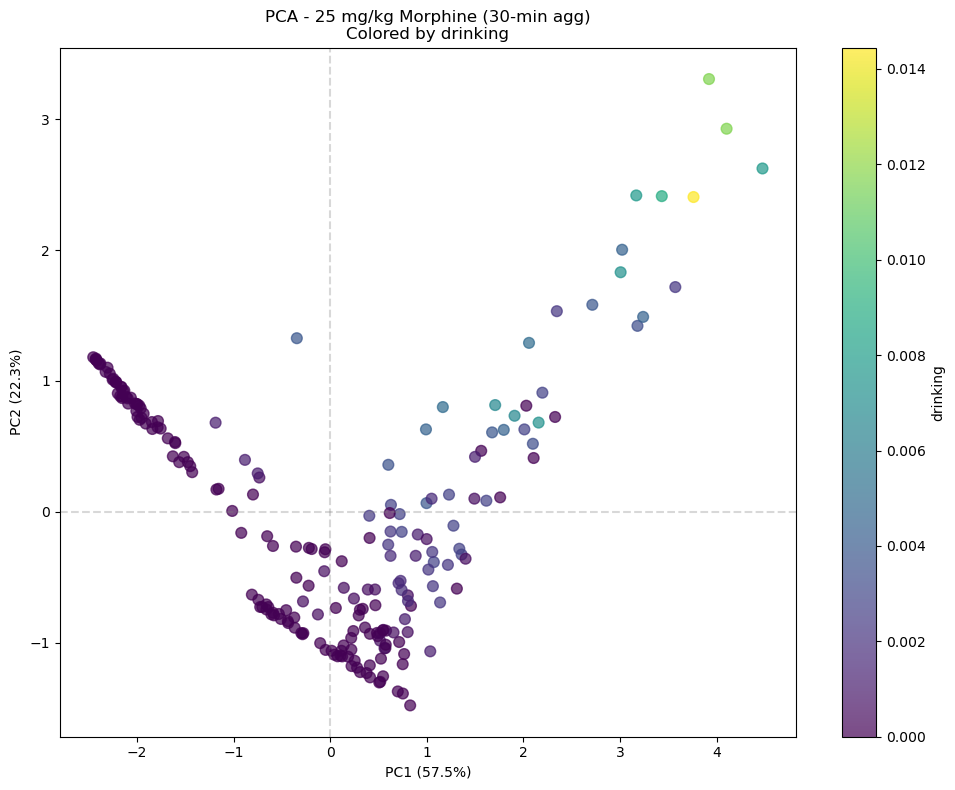

Saved: pcas_30min/pca_drinking.png


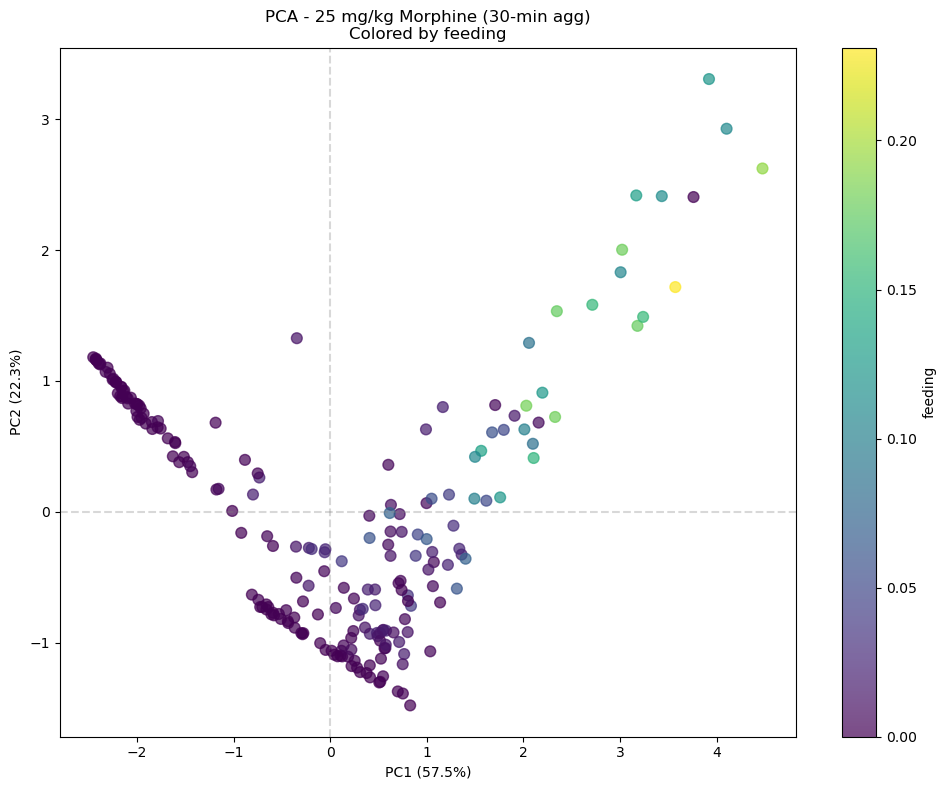

Saved: pcas_30min/pca_feeding.png


In [31]:
for feat in features_to_use:
    feat_name = feat.replace('animal_bouts.', '')
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(df_pca_agg['PC1'], df_pca_agg['PC2'],
                         c=df_pca_agg[feat], cmap='viridis', alpha=0.7, s=60)
    plt.colorbar(scatter, ax=ax, label=feat_name)
    
    ax.set_xlabel(f"PC1 ({pca_agg.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca_agg.explained_variance_ratio_[1]*100:.1f}%)")
    ax.set_title(f"PCA - 25 mg/kg Morphine (30-min agg)\nColored by {feat_name}")
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/pca_{feat_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

    plt.close()
    print(f"Saved: {OUTPUT_DIR}/pca_{feat_name}.png")


RUNNING PCA - ALL DOSE GROUPS
Total rows: 648
By dose group:
dose_group
5 mg/kg     219
25 mg/kg    216
Vehicle     213
Name: count, dtype: int64

Explained Variance:
  PC1: 40.0%
  PC2: 24.1%


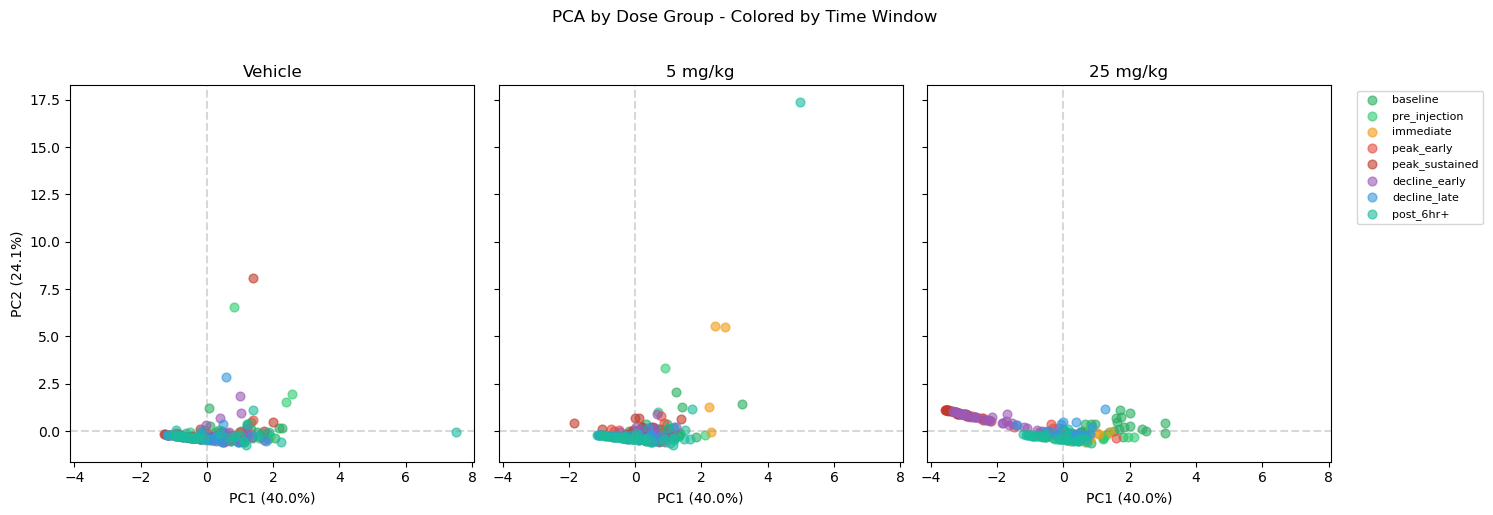

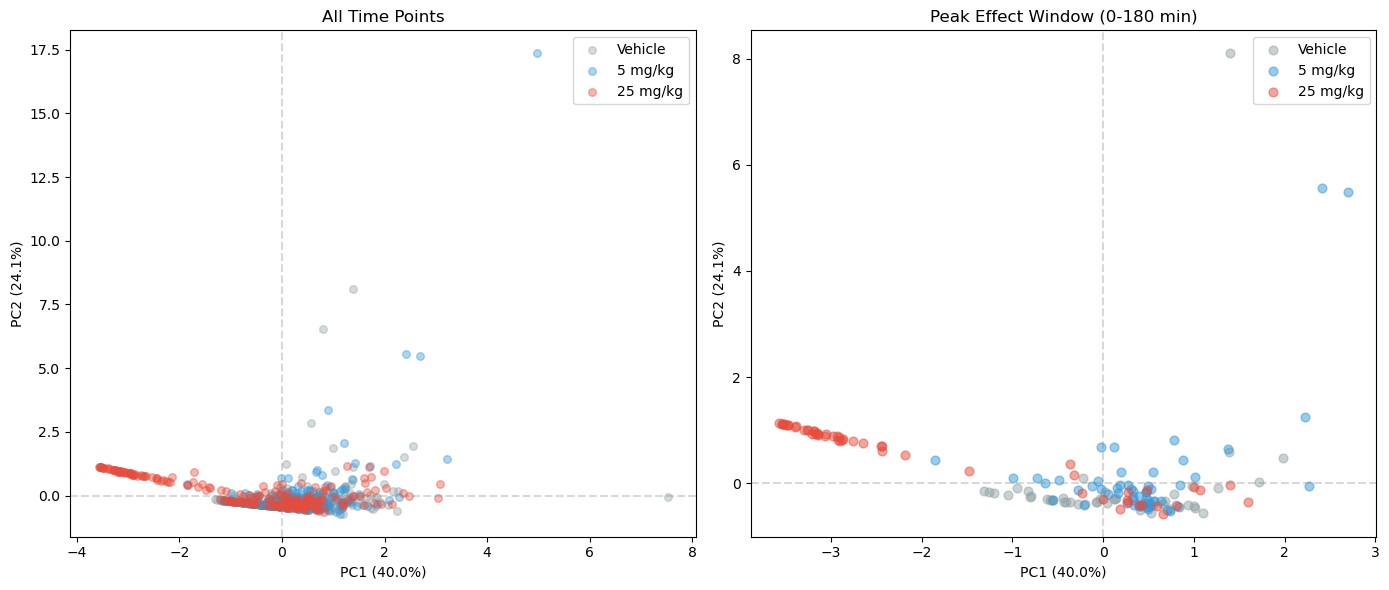


CENTROID ANALYSIS

Mean PC coordinates by dose and time window:
                            PC1   PC2
dose_group time_window               
25 mg/kg   baseline        0.96  0.01
           decline_early  -1.94  0.53
           decline_late    0.18 -0.09
           immediate       0.74 -0.30
           peak_early     -1.18  0.28
           peak_sustained -3.21  0.97
           post_6hr+      -0.32 -0.31
           pre_injection   0.69 -0.26
5 mg/kg    baseline        0.78  0.02
           decline_early   0.36 -0.21
           decline_late   -0.18 -0.29
           immediate       1.18  1.22
           peak_early      0.27 -0.08
           peak_sustained  0.25 -0.09
           post_6hr+       0.28  0.15
           pre_injection   0.26  0.03
Vehicle    baseline        0.69 -0.14
           decline_early   0.25 -0.14
           decline_late   -0.12 -0.20
           immediate       0.56 -0.32
           peak_early      0.61 -0.29
           peak_sustained -0.21  0.08
           post_6hr+   

In [32]:
# =============================================================================
# RUN PCA ON ALL DOSE GROUPS
# =============================================================================

print("\n" + "="*60)
print("RUNNING PCA - ALL DOSE GROUPS")
print("="*60)

# Use ALL data, not just 25 mg/kg
df_pca = df_agg.dropna(subset=features_to_use).copy()
print(f"Total rows: {len(df_pca):,}")
print(f"By dose group:")
print(df_pca['dose_group'].value_counts())

# Fit PCA on all data
X = df_pca[features_to_use].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca['PC1'] = X_pca[:, 0]
df_pca['PC2'] = X_pca[:, 1]

print(f"\nExplained Variance:")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")

# =============================================================================
# PLOT: ALL DOSE GROUPS BY TIME WINDOW (FACETED)
# =============================================================================

dose_groups = ['Vehicle', '5 mg/kg', '25 mg/kg']
dose_colors = {'Vehicle': '#95a5a6', '5 mg/kg': '#3498db', '25 mg/kg': '#e74c3c'}

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for idx, dose in enumerate(dose_groups):
    ax = axes[idx]
    df_dose = df_pca[df_pca['dose_group'] == dose]
    
    for window in window_order:
        mask = df_dose['time_window'] == window
        if mask.sum() > 0:
            ax.scatter(df_dose.loc[mask, 'PC1'], df_dose.loc[mask, 'PC2'],
                       c=window_colors[window], alpha=0.6, s=40, label=window)
    
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_title(dose)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.suptitle("PCA by Dose Group - Colored by Time Window", y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/pca_all_doses_by_time.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# PLOT: OVERLAY ALL DOSES (COLORED BY DOSE)
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: All time points
ax = axes[0]
for dose in dose_groups:
    mask = df_pca['dose_group'] == dose
    ax.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
               c=dose_colors[dose], alpha=0.4, s=30, label=dose)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("All Time Points")
ax.legend()
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# Right: Peak effect only (30-180 min post-injection)
ax = axes[1]
peak_windows = ['immediate', 'peak_early', 'peak_sustained']
for dose in dose_groups:
    mask = (df_pca['dose_group'] == dose) & (df_pca['time_window'].isin(peak_windows))
    ax.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
               c=dose_colors[dose], alpha=0.5, s=40, label=dose)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("Peak Effect Window (0-180 min)")
ax.legend()
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/pca_dose_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# QUANTIFY: CENTROID TRAJECTORIES
# =============================================================================

print("\n" + "="*60)
print("CENTROID ANALYSIS")
print("="*60)

centroids = df_pca.groupby(['dose_group', 'time_window'])[['PC1', 'PC2']].mean()
print("\nMean PC coordinates by dose and time window:")
print(centroids.round(2))